# HW3

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from numba import njit
from time import time

## Problem 1

C:\Users\yqiu7\AppData\Local\Temp\ipykernel_27988\3288770614.py:29: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u = spsolve(A, rho)  # Solve the linear system


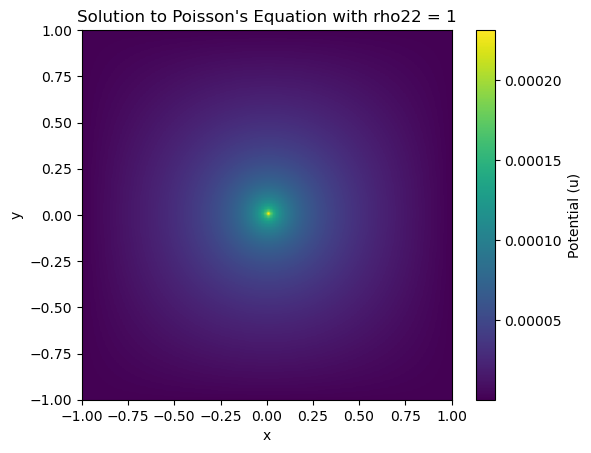

In [10]:
def generate_laplace_matrix(N):
    nsq = N*N
    A   = np.zeros((nsq,nsq))    
    # TODO
    for i in range(N):
        for j in range(N):
            index = i * N + j  
            A[index, index] = 4
            if j > 0:
                A[index, index - 1] = -1
            if j < N - 1:
                A[index, index + 1] = -1
            if i > 0:
                A[index, index - N] = -1
            if i < N - 1:
                A[index, index + N] = -1

    return A
def setup_rho(N):
    rho = np.zeros((N, N))
    rho[N//2, N//2] = 1  # Set the center to 1
    return rho.flatten()

def solve_poisson(N):
    dx = 2.0 / (N - 1)  # Grid spacing
    A = generate_laplace_matrix(N)
    rho = setup_rho(N) * dx**2  # Multiply by dx^2 for proper discretization

    u = spsolve(A, rho)  # Solve the linear system
    return u.reshape((N, N))

# Parameters
N = 128 # Grid size

# Solve the system
u = solve_poisson(N)

# Plot the solution
plt.imshow(u, extent=[-1, 1, -1, 1], origin="lower", cmap="viridis")
plt.colorbar(label="Potential (u)")
plt.title("Solution to Poisson's Equation with rho22 = 1")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## Problem 2

c:\Users\yqiu7\.conda\envs\ComputationalPhysics113\Lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


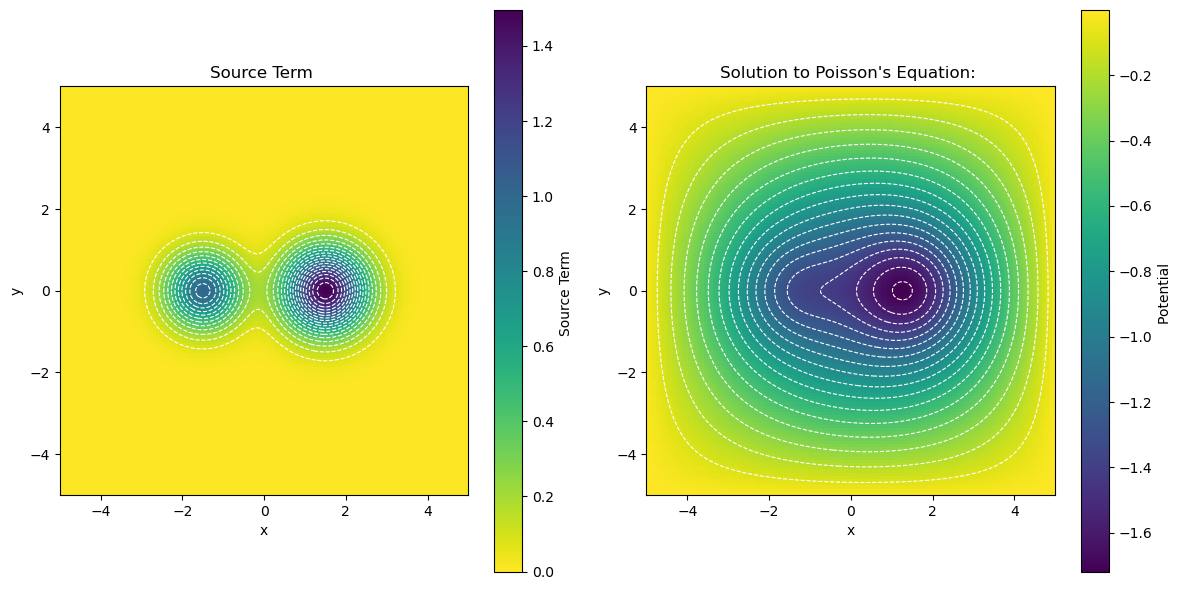

In [13]:
@njit(nopython=True)
def gauss_seidel_poisson(u, rho, dx, dy, N):
    for i in range(1, N + 1):  
        for j in range(1, N + 1):
            u[i, j] = 0.25 * (
                u[i-1, j] + u[i+1, j] +
                u[i, j-1] + u[i, j+1] - 
                dx**2 * rho[i-1, j-1]
            )

def update_bc(u, N):
    u[0, :] = 0.0  # Top boundary
    u[-1, :] = 0.0  # Bottom boundary
    u[:, 0] = 0.0  # Left boundary
    u[:, -1] = 0.0  # Right boundary

def solve_poisson(N, tol=1e-6, max_iter=30000):
    """
    Solve Poisson's equation using the Gauss-Seidel method.
    """
    dx = 10.0 / (N - 1)  # Now the domain is [-5, 5]
    dy = 10.0 / (N - 1)  # Now the domain is [-5, 5]
    
    x = np.linspace(-5, 5, N)
    y = np.linspace(-5, 5, N)
    X, Y = np.meshgrid(x, y)
    
    # Calculate r1^2 and r2^2
    r1_sq = (X + 1.5)**2 + Y**2
    r2_sq = (X - 1.5)**2 + Y**2
    # Compute the source term rho
    rho = np.exp(-5/4 * r1_sq) + (3/2) * np.exp(-r2_sq)
    
    # Initialize solution array (with ghost cells)
    u = np.zeros((N + 2, N + 2))
    
    # Update boundary conditions
    update_bc(u, N)
    
    # Initialize error tracking
    errors = []
    
    for k in range(max_iter):
        uold = u.copy()
        gauss_seidel_poisson(u, rho, dx, dy, N)    
        # Compute error
        error = np.linalg.norm(u - uold, ord=np.inf)
        errors.append(error)
        # Check for convergence
        if error < tol:
            return u[1:-1, 1:-1], rho, X, Y, errors, k + 1

    return u[1:-1, 1:-1], rho, X, Y, errors, max_iter

# Solve Poisson's equation for a 128x128 grid
N = 128
u, rho, X, Y, errors, iterations = solve_poisson(N)

# Plot the source function (rho) as a color plot and contour plot
plt.figure(figsize=(12, 6))

# Color plot of rho
plt.subplot(1, 2, 1)
img = plt.imshow(rho, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis_r')
plt.colorbar(img, label='Source Term ')
plt.title("Source Term ")
plt.xlabel("x")
plt.ylabel("y")

# Contour plot of rho overlaid on color plot (white dashed lines)
plt.contour(X, Y, rho, levels=20, colors='white', linestyles='dashed', linewidths=0.8)

# Contour plot of u
plt.subplot(1, 2, 2)
img = plt.imshow(u, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis')
plt.colorbar(img, label='Potential ')
plt.title("Solution to Poisson's Equation: ")
plt.xlabel("x")
plt.ylabel("y")

# Contour plot of u overlaid on color plot (white dashed lines)
plt.contour(X, Y, u, levels=20, colors='white', linestyles='dashed', linewidths=0.8)

plt.tight_layout()
plt.show()


## Problem 3

c:\Users\yqiu7\.conda\envs\ComputationalPhysics113\Lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


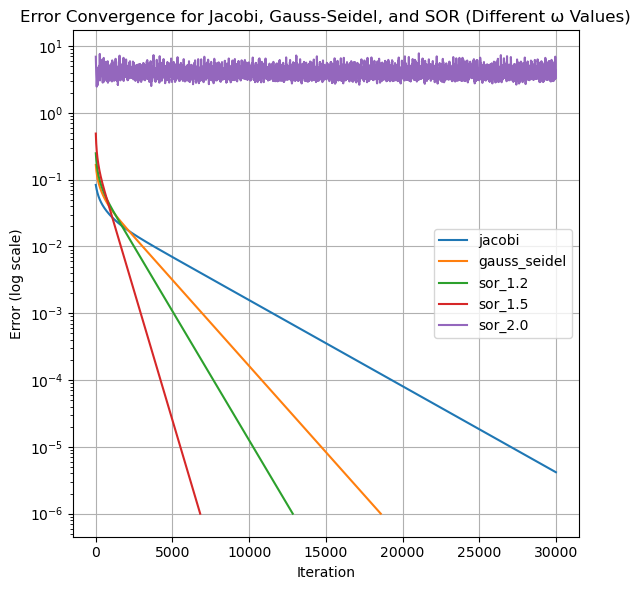

In [14]:
@njit(nopython=True)
def jacobi_poisson(u, rho, dx, dy, N):
    u_new = np.copy(u)
    for i in range(1, N + 1):  
        for j in range(1, N + 1):
            u_new[i, j] = 0.25 * (
                u[i-1, j] + u[i+1, j] +
                u[i, j-1] + u[i, j+1] - 
                dx**2 * rho[i-1, j-1]
            )
    return u_new

@njit(nopython=True)
def gauss_seidel_poisson(u, rho, dx, dy, N):
    for i in range(1, N + 1):  
        for j in range(1, N + 1):
            u[i, j] = 0.25 * (
                u[i-1, j] + u[i+1, j] +
                u[i, j-1] + u[i, j+1] - 
                dx**2 * rho[i-1, j-1]
            )

@njit(nopython=True)
def sor_poisson(u, rho, dx, dy, N, omega):
    for i in range(1, N + 1):  
        for j in range(1, N + 1):
            u[i, j] = (1 - omega) * u[i, j] + 0.25 * omega * (
                u[i-1, j] + u[i+1, j] +
                u[i, j-1] + u[i, j+1] - 
                dx**2 * rho[i-1, j-1]
            )

def update_bc(u, N):
    u[0, :] = 0.0  # Top boundary
    u[-1, :] = 0.0  # Bottom boundary
    u[:, 0] = 0.0  # Left boundary
    u[:, -1] = 0.0  # Right boundary

def solve_poisson(N, method='gauss_seidel', omega=1.5, tol=1e-6, max_iter=30000):
    """
    Solve Poisson's equation using the specified method.
    """

    dx = 10.0 / (N - 1)  # Now the domain is [-5, 5]
    dy = 10.0 / (N - 1)  # Now the domain is [-5, 5]
    
    x = np.linspace(-5, 5, N)
    y = np.linspace(-5, 5, N)
    X, Y = np.meshgrid(x, y)
    
    # Calculate r1^2 and r2^2
    r1_sq = (X + 1.5)**2 + Y**2
    r2_sq = (X - 1.5)**2 + Y**2
    # Compute the source term rho
    rho = np.exp(-5/4 * r1_sq) + (3/2) * np.exp(-r2_sq)
    
    # Initialize solution array (with ghost cells)
    u = np.zeros((N + 2, N + 2))
    
    # Update boundary conditions
    update_bc(u, N)
    
    # Initialize error tracking
    errors = []
    
    for k in range(max_iter):
        uold = u.copy()
        
        # Perform the chosen method
        if method == 'jacobi':
            u = jacobi_poisson(u, rho, dx, dy, N)
        elif method == 'gauss_seidel':
            gauss_seidel_poisson(u, rho, dx, dy, N)
        elif method == 'sor':
            sor_poisson(u, rho, dx, dy, N, omega)
        
        # Compute error
        error = np.linalg.norm(u - uold, ord=np.inf)
        errors.append(error)
        
        # Check for convergence
        if error < tol:
            return u[1:-1, 1:-1], rho, X, Y, errors, k + 1

    return u[1:-1, 1:-1], rho, X, Y, errors, max_iter

# Solve Poisson's equation for a 128x128 grid using each method and track errors
N = 128
omega_values = [1.2, 1.5, 2.0]
errors_dict = {'jacobi': [], 'gauss_seidel': [], 'sor_1.2': [], 'sor_1.5': [], 'sor_2.0': []}

# Jacobi method
_, _, _, _, errors, _ = solve_poisson(N, method='jacobi')
errors_dict['jacobi'] = errors

# Gauss-Seidel method
_, _, _, _, errors, _ = solve_poisson(N, method='gauss_seidel')
errors_dict['gauss_seidel'] = errors

# SOR method for different omega values
for omega in omega_values:
    _, _, _, _, errors, _ = solve_poisson(N, method='sor', omega=omega)
    errors_dict[f'sor_{omega}'] = errors

# Plot errors as a function of iterations for different methods and omega values
plt.figure(figsize=(6, 6))

for label, errors in errors_dict.items():
    plt.plot(range(len(errors)), errors, label=label)

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Error (log scale)")
plt.title("Error Convergence for Jacobi, Gauss-Seidel, and SOR (Different ω Values)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Problem 4

c:\Users\yqiu7\.conda\envs\ComputationalPhysics113\Lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
C:\Users\yqiu7\AppData\Local\Temp\ipykernel_27988\2505618513.py:67: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u_flat = spsolve(A, b)
C:\Users\yqiu7\AppData\Local\Temp\ipykernel_27988\2505618513.py:67: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u_flat = spsolve(A, b)


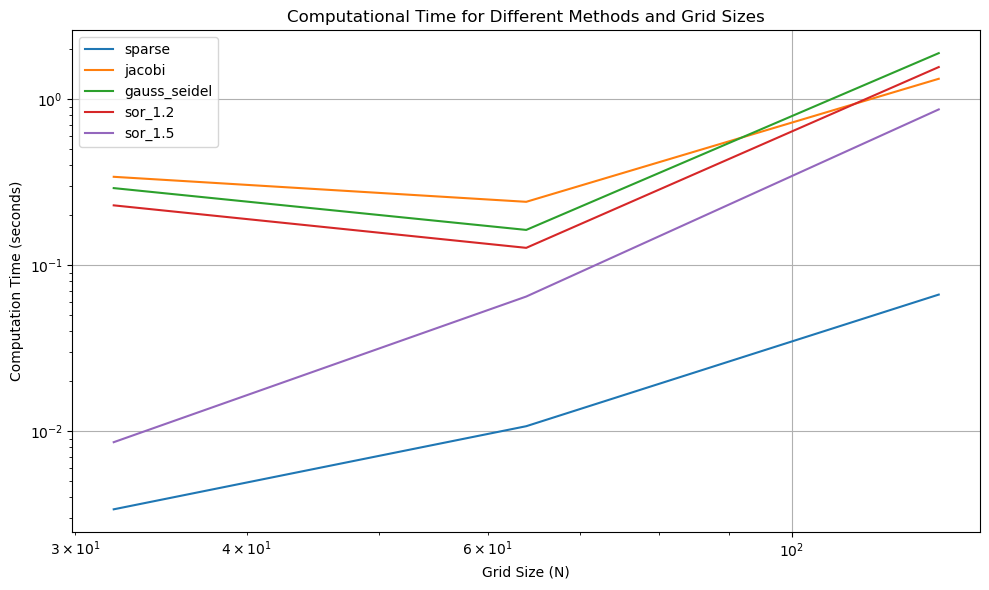

In [19]:
from scipy.sparse.linalg import spsolve
import time
@njit(nopython=True)
def jacobi_poisson(u, rho, dx, dy, N):
    u_new = np.copy(u)
    for i in range(1, N + 1):  
        for j in range(1, N + 1):
            u_new[i, j] = 0.25 * (
                u[i-1, j] + u[i+1, j] +
                u[i, j-1] + u[i, j+1] - 
                dx**2 * rho[i-1, j-1]
            )
    return u_new

@njit(nopython=True)
def gauss_seidel_poisson(u, rho, dx, dy, N):
    for i in range(1, N + 1):  
        for j in range(1, N + 1):
            u[i, j] = 0.25 * (
                u[i-1, j] + u[i+1, j] +
                u[i, j-1] + u[i, j+1] - 
                dx**2 * rho[i-1, j-1]
            )

@njit(nopython=True)
def sor_poisson(u, rho, dx, dy, N, omega):
    for i in range(1, N + 1):  
        for j in range(1, N + 1):
            u[i, j] = (1 - omega) * u[i, j] + 0.25 * omega * (
                u[i-1, j] + u[i+1, j] +
                u[i, j-1] + u[i, j+1] - 
                dx**2 * rho[i-1, j-1]
            )

def update_bc(u, N):
    u[0, :] = 0.0  # Top boundary
    u[-1, :] = 0.0  # Bottom boundary
    u[:, 0] = 0.0  # Left boundary
    u[:, -1] = 0.0  # Right boundary

def solve_poisson_sparse(N, tol=1e-7, max_iter=30000):

    dx = 10.0 / (N - 1)  
    dy = 10.0 / (N - 1)  
    

    x = np.linspace(-5, 5, N)
    y = np.linspace(-5, 5, N)
    X, Y = np.meshgrid(x, y)
    
    r1_sq = (X + 1.5)**2 + Y**2
    r2_sq = (X - 1.5)**2 + Y**2
    rho = np.exp(-5/4 * r1_sq) + (3/2) * np.exp(-r2_sq)
    
    # Create the sparse matrix A
    diagonals = np.array([-1] * (N * N), dtype=float)
    main_diag = np.array([4] * (N * N), dtype=float)
    upper_diag = np.array([-1] * (N * N - 1), dtype=float)
    lower_diag = np.array([-1] * (N * N - 1), dtype=float)
    
    A = diags([diagonals, main_diag, upper_diag, lower_diag], [-N, 0, -1, 1], shape=(N * N, N * N))
    
    # Flatten the source term
    b = -rho.flatten() * dx**2

    # Solve the sparse system
    u_flat = spsolve(A, b)
    u = u_flat.reshape((N, N))
    
    return u, rho, X, Y

def solve_poisson(N, method='gauss_seidel', omega=1.5, tol=1e-7, max_iter=30000):
    dx = 10.0 / (N - 1)  
    dy = 10.0 / (N - 1)  
    
    x = np.linspace(-5, 5, N)
    y = np.linspace(-5, 5, N)
    X, Y = np.meshgrid(x, y)
    
    r1_sq = (X + 1.5)**2 + Y**2
    r2_sq = (X - 1.5)**2 + Y**2
    rho = np.exp(-5/4 * r1_sq) + (3/2) * np.exp(-r2_sq)
    
    u = np.zeros((N + 2, N + 2))
    update_bc(u, N)
    
    errors = []
    for k in range(max_iter):
        uold = u.copy()
        
        if method == 'jacobi':
            u = jacobi_poisson(u, rho, dx, dy, N)
        elif method == 'gauss_seidel':
            gauss_seidel_poisson(u, rho, dx, dy, N)
        elif method == 'sor':
            sor_poisson(u, rho, dx, dy, N, omega)
        
        error = np.linalg.norm(u - uold, ord=np.inf)
        errors.append(error)
        
        if error < tol:
            return u[1:-1, 1:-1], rho, X, Y, errors, k + 1

    return u[1:-1, 1:-1], rho, X, Y, errors, max_iter

# Measure and plot computing times for different methods and grid sizes
grid_sizes = [32, 64, 128]
methods = ['sparse', 'jacobi', 'gauss_seidel', 'sor_1.2', 'sor_1.5']
times = {method: [] for method in methods}

for N in grid_sizes:
    # Sparse method
    start_time = time.time()
    solve_poisson_sparse(N)
    times['sparse'].append(time.time() - start_time)
    
    # Jacobi method
    start_time = time.time()
    solve_poisson(N, method='jacobi')
    times['jacobi'].append(time.time() - start_time)
    
    # Gauss-Seidel method
    start_time = time.time()
    solve_poisson(N, method='gauss_seidel')
    times['gauss_seidel'].append(time.time() - start_time)
    
    # SOR method (with omega=1.2)
    start_time = time.time()
    solve_poisson(N, method='sor', omega=1.2)
    times['sor_1.2'].append(time.time() - start_time)
    
    # SOR method (with omega=1.5)
    start_time = time.time()
    solve_poisson(N, method='sor', omega=1.5)
    times['sor_1.5'].append(time.time() - start_time)

# Plot computing times on log-log scale
plt.figure(figsize=(10, 6))

for method in methods:
    plt.plot(grid_sizes, times[method], label=method)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Grid Size (N)')
plt.ylabel('Computation Time (seconds)')
plt.title('Computational Time for Different Methods and Grid Sizes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 1. Sparse Matrix Solver:
As the grid resolution increases, the computation time grows exponentially. However, it is an exact method and achieves the fastest convergence rate.

### 2. Jacobi Method:
The Jacobi method is a simple iterative approach where the entire solution is updated at each iteration. As the grid resolution increases, the computation time also grows. The convergence rate is relatively slow because it does not utilize the updated results during the current iteration, making it less efficient for large grids.

### 3. Gauss-Seidel Method:
The Gauss-Seidel method is slightly faster than the Jacobi method because it immediately uses the updated values for subsequent calculations during the same iteration. This makes it more efficient in the convergence process compared to the Jacobi method. The computation time increases with grid resolution, but the rate of increase is faster than that of the Jacobi method.

### 4. SOR (Successive Over-Relaxation) Method:
**Computation Time Trend**: The SOR method is a variation of the Gauss-Seidel method, introducing a relaxation factor (𝜔) to accelerate convergence. The choice of the relaxation factor affects the convergence speed and, consequently, the computation time. Larger values of 𝜔 typically lead to faster convergence, potentially reducing computation time.